# Project Overview
Flux Balance Analysis (FBA) is a mathematical approach for simulating metabolism in genome-scale reconstructions of metabolic networks. These network reconstructions contain all of the known metabolic reactions in an organism and the genes that encode various enzymes. Using these networks, the following predictions can be made:  
1. Whether an organism grows under different conditions, 
2. The rate at which the organism grows, and 
3. The rate at which a metabolite is produced  
  
Given a specific media and organism, we aim to create a dynamic database containing gap-filled models and the results of FBA under various conditions, while:
* Providing an interactive graphical interface for visualizing gap-filled metabolic networks
* Facilitating the troubleshooting of why an organism grows/does not grow given specific environmental conditions
* Providing graphic visualizations of the simulated growth curves (biomass vs. time) and growth in time and space  
![Workflow](Images/pipeline.png)  

This tutorial will be focusing on *Pseudomonas simiae WCS417* growing on a RCH2_defined_no_Carbon media (defined by Adam Deutschbauer in [Supplementary TableS18_Medias](https://www.nature.com/articles/s41586-018-0124-0#Sec36). The genome can be downloaded from [NCBI](https://www.ncbi.nlm.nih.gov/assembly/GCF_000698265.1). 

# Setting up the Environment
You can create an Anaconda environment using:

    conda create --name [name]
    conda activate [name]
    
The following dependency installations assume you are using Anaconda. However, if you do not want to create an environment you can change each command to `pip install`

# Creating a Gap-filled Model
**As a USER, I would like to upload my own model and media so that I can create a gap-filled model**   
In order to run FBA, a gap-filled model is necessary to predict the uptake and secretion capabilities of an organism. Supplying a media file will guarantee that the model is able to reproduce growth in a experimentally verified media, i.e. gap-filling will identify the minimal set of biochemical reactions for a model to produce biomass in a specified media.  

[CarveMe](https://carveme.readthedocs.io/en/latest/usage.html) will be used to create such a model given a media. The user will supply the accession number or choose an organism from the database.  
  
*CarveMe Dependencies*: diamond, cplex (requires license)

In [ ]:
!pip install carveme

In [ ]:
!conda install -c bioconda diamond

[Cplex](https://www.ibm.com/products/ilog-cplex-optimization-studio) can be downloaded from IBM and requires a license. Academic licenses are free.  
Once downloaded, you can install it using:  

## Media File
The user can choose from a set of pre-defined media (LB, M9, RCH2, etc.) in the database, or upload their own media file. This file must be a tab-separated file with the following columns:
* *medium*: short id to identify the medium (example: X)
* *compound*: compound id (example: glc) in BiGG format  
* *concentration*: compound concentration in mmol/cm<sup>3</sup>
* *min flux*: lower bound of compound uptake
* *vmax*:
* *km*: 

Optional columns:
* *description*: description of the medium (example: Our magic X formula)
* *name*: compound name (example: Glucose)

**NOTE: only metabolite ids from the [BiGG](http://bigg.ucsd.edu) database is supported.**  
  
An example of this media file is as follows:
![Example media](Images/example_media.png)

## Starting from Genome
Given a NCBI RefSeq accession number by the user, `CarveMe` will be used to first build a genome-scale metabolic model and then a gap-filled model in COBRA format.

In [ ]:
# Create metabolic model (not gap-filled) for storage in the database 
# if the same model needs to be run with a different media
!carve --refseq GCF_000698265.1 --cobra -o GCF_000698265.1.xml

# Create a gap-filled model
!gapfill GCF_000698265.1.xml --cobra -g RCH2 -i RCH2 --mediadb RCH2_with_glucose.tsv 

This will create 4 files: 
1. GCF_000698265.1.faa.gz - protein FASTA file	
2. GCF_000698265.1.faa.tsv - gene matching by homology search using diamond
3. GCF_000698265.1.xml - metabolic model 
4. GCF_000698265.1_gapfill.xml - gap-filled metabolic modle

## Output
Gap-filled metabolic models in SBML format will be generated containing compounds, reactions, genes, and pathways. Below is an example output file:  
![Example XML](Images/example_output.png)  

### Retrieving Organism Name
While the RefSeq accession is a unique identifier, it is not easy to read. We will extract the metadata using `Biopython`. This will provide us the organism name for ease of selecting already-built models.

In [ ]:
!conda install biopython 

In [99]:
from Bio import Entrez

refseq = 'GCF_000698265.1'

handle = Entrez.esearch(db="assembly", term=refseq)
record = Entrez.read(handle)

# Get Assembly Summary
esummary_handle = Entrez.esummary(db="assembly", id=record['IdList'], report="full")
esummary_record = Entrez.read(esummary_handle)

# Organism and strain
organism = esummary_record['DocumentSummarySet']['DocumentSummary'][0]['SpeciesName']
try: 
    strain = esummary_record['DocumentSummarySet']['DocumentSummary'][0]['Biosource']['InfraspeciesList'][0]['Sub_value']
except:
    strain = ''
print(organism, strain)

Pseudomonas simiae WCS417


# Running FBA
**As a USER, I would like to select my own set of conditions so that I can simulate an organism's growth under different conditions**  
Now that we have the gap-filled model, [COMETS](https://github.com/segrelab/comets) will be used to simulate growth and visualize growth curves and growth in time and space via dynamic FBA. This will allow us to answer the following questions:
1. How does a microorganism grow under different sources/conditions?
2. What is the flow of a given metabolite through the metabolic network?
3. How do the growth rates of a specific organism compare across different conditions and/or media?
4. What are the metabolites and their fluxes in a given pathway?
5. What are the upper and lower bounds of a particular reaction?  
  
*COMETS Dependencies*: CobraPy, Gurobi, Java  
**The COMETS software can be downloaded here:** https://www.runcomets.org/installation

In [ ]:
!pip install cobra

In [ ]:
# Install python interface
!pip install cometspy

[Gurobi](https://www.gurobi.com/documentation/9.1/quickstart_mac/software_installation_guid.html) can be downloaded from their site and requires a license. Academic licenses are free.  
Once downloaded, you can install it using:  

Make sure that you set GUROBI_COMETS_HOME, GUROBI_HOME, or COMETS_GUROBI_HOME as an environmental variable or COMETS will not run. Below is how you could do this on a Mac.

In [ ]:
import os
os.environ['COMETS_HOME']='/Applications/COMETS'
os.environ['GUROBI_COMETS_HOME']='/Library/gurobi902/mac64'
os.environ['LD_LIBRARY_PATH']='/Library/gurobi902/mac64/lib/'

## Growth Under Different Conditions
Within the database, 

In [ ]:
import cobra
import cometspy as c

# Load the gap-filled model
model = cobra.io.read_sbml_model('CarveMe/GCF_000698265.1_gapfill.xml')
# Create a COMETS model
comets_model = c.model(model)

In [67]:
medium = model.medium
medium['EX_glc__D_e'] = 0.0
medium['EX_fru_e'] = 10.0
model.medium = medium
model.slim_optimize()

0.8649732051212797

In [68]:
cobra.io.save_json_model(model, 'escher.json')

In [3]:
# We can view different properties of our model
# Summary of the model
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.003881,0,0.00%
cl_e,EX_cl_e,0.003881,0,0.00%
cobalt2_e,EX_cobalt2_e,7.456E-05,0,0.00%
cu2_e,EX_cu2_e,0.0005287,0,0.00%
fe2_e,EX_fe2_e,0.01083,0,0.00%
glc__D_e,EX_glc__D_e,10,6,100.00%
k_e,EX_k_e,0.1455,0,0.00%
mg2_e,EX_mg2_e,0.006468,0,0.00%
mn2_e,EX_mn2_e,0.0005152,0,0.00%
nh4_e,EX_nh4_e,8.349,0,0.00%


In [18]:
model.metabolites.query('Sucrose', attribute='name')

[<Metabolite sucr_c at 0x7fdff4a65fd0>,
 <Metabolite suc6p_c at 0x7fdff4acce50>,
 <Metabolite sucr_e at 0x7fdff4c81450>,
 <Metabolite sucr_p at 0x7fdff4c724d0>]

In [4]:
# All exchange reactions
model.exchanges

[<Reaction EX_glc__D_e at 0x7fc428a44690>,
 <Reaction EX_h2o_e at 0x7fc428a44cd0>,
 <Reaction EX_14glucan_e at 0x7fc428a443d0>,
 <Reaction EX_h_e at 0x7fc428a4f590>,
 <Reaction EX_hco3_e at 0x7fc428a24790>,
 <Reaction EX_2hxmp_e at 0x7fc428a4f250>,
 <Reaction EX_2pglyc_e at 0x7fc428a4fd50>,
 <Reaction EX_34dhbz_e at 0x7fc4289e4390>,
 <Reaction EX_leu__L_e at 0x7fc428a4fad0>,
 <Reaction EX_3hoxpac_e at 0x7fc428a4fb90>,
 <Reaction EX_3mb_e at 0x7fc428a5b6d0>,
 <Reaction EX_3oxoadp_e at 0x7fc4289fcb10>,
 <Reaction EX_4hbald_e at 0x7fc428a4fe90>,
 <Reaction EX_4hba_e at 0x7fc4289a8510>,
 <Reaction EX_4hbz_e at 0x7fc428a5ba50>,
 <Reaction EX_ala__L_e at 0x7fc428a5ba10>,
 <Reaction EX_cl_e at 0x7fc428a5bd90>,
 <Reaction EX_arab__L_e at 0x7fc4289fcbd0>,
 <Reaction EX_4abut_e at 0x7fc4289fcad0>,
 <Reaction EX_acac_e at 0x7fc428a5bd50>,
 <Reaction EX_acald_e at 0x7fc428a5bf10>,
 <Reaction EX_acgam_e at 0x7fc428a5be50>,
 <Reaction EX_ac_e at 0x7fc428a5b390>,
 <Reaction EX_chol_e at 0x7fc428a5bc1

In [5]:
# Medium (RCH2_defined_no_Carbon)
# Will be used to build the medium in COMETS and change conditions
model.medium

{'EX_glc__D_e': 10.0,
 'EX_h2o_e': 10.0,
 'EX_h_e': 10.0,
 'EX_cl_e': 10.0,
 'EX_pi_e': 10.0,
 'EX_nh4_e': 10.0,
 'EX_k_e': 10.0,
 'EX_ca2_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_mn2_e': 10.0,
 'EX_cobalt2_e': 10.0,
 'EX_zn2_e': 10.0,
 'EX_cu2_e': 10.0,
 'EX_o2_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_mobd_e': 10.0,
 'EX_no3_e': 10.0,
 'EX_pydxn_e': 10.0,
 'EX_so4_e': 10.0}

In [ ]:
medium = model.medium
medium['EX_glc__D_e'] = 0.0
medium['EX_fru_e'] = 10.0
model.medium = medium
model.slim_optimize()

In [46]:
# Create a parameters object with default values 
params = c.params()
# Change the value of a parameter, for example number of simulation cycles
params.set_param('maxCycles', 10000)
params.set_param('BiomassLogRate', 1000)
params.set_param('timeStep', 0.01)
params.set_param('spaceWidth', 1.0)

# Set some parameters to True, in order to save the output
params.set_param('writeTotalBiomassLog', True)
params.set_param('writeBiomassLog', True)
params.set_param('writeFluxLog', True)
params.set_param('writeMediaLog', True)

# See avaliable parameters and their values
params.show_params()

,VALUE,UNITS
BiomassLogName,biomass.txt,
BiomassLogRate,1000,cycles
FluxLogName,flux_out,
FluxLogRate,5,cycles
MediaLogName,media_out,
MediaLogRate,5,cycles
SpecificMediaLogName,specific_media.txt,
TotalBiomassLogName,total_biomass_out.txt,
activateRate,0.001,
addRate,0,additions /generation


In [47]:
# Create 1x1 layout of model
test_tube = c.layout()

# set the model's initial biomass
comets_model.initial_pop = [0, 0, 5e-6]

# Add nutrients to test tube
for metabolite, flux in model.medium.items():
    test_tube.set_specific_metabolite(metabolite[3:], flux)

test_tube.add_model(comets_model)

building empty layout model
models will need to be added with layout.add_model()


In [48]:
simulation = c.comets(test_tube, params)
simulation.run()


Running COMETS simulation ...
Done!


# Graphical Outputs

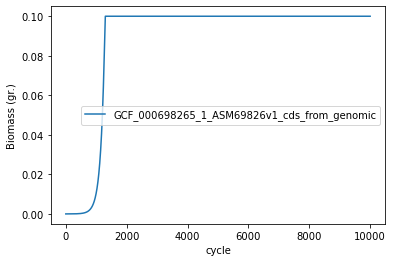

In [51]:
import matplotlib.pyplot as plt
ax = simulation.total_biomass.plot(x = 'cycle')
ax.set_ylabel("Biomass (gr.)");

In [61]:
comets_model.metabolites.head()

,METABOLITE_NAMES
0,10fthf_c
1,adp_c
2,atp_c
3,glu__L_c
4,pi_c


In [52]:
comets_model.reactions.head()

,REACTION_NAMES,ID,LB,UB,EXCH,EXCH_IND,V_MAX,KM,HILL
0,12DGR161tipp,1,0.0,1000.0,False,0,NaN,NaN,NaN
1,12DGR181tipp,2,0.0,1000.0,False,0,NaN,NaN,NaN
2,14GLUCANabcpp,3,0.0,1000.0,False,0,NaN,NaN,NaN
3,14GLUCANtexi,4,0.0,1000.0,False,0,NaN,NaN,NaN
4,1PPDCRc,5,0.0,1000.0,False,0,NaN,NaN,NaN


In [68]:
model.metabolites.pi_c.summary()

Percent,Flux,Reaction,Definition
0.38%,0.223,ADSS,asp__L_c + gtp_c + imp_c --> dcamp_c + gdp_c + 2.0 h_c + pi_c
0.38%,0.2206,AGPR,acg5sa_c + nadp_c + pi_c <=> acg5p_c + h_c + nadph_c
0.13%,0.07456,ALAALAr,2.0 ala__D_c + atp_c <=> adp_c + alaala_c + h_c + pi_c
1.46%,0.8511,ASADi,4pasp_c + h_c + nadph_c --> aspsa_c + nadp_c + pi_c
0.42%,0.2471,ASPCT,asp__L_c + cbp_c --> cbasp_c + h_c + pi_c
0.49%,0.2841,CHORS,3psme_c --> chor_c + pi_c
0.24%,0.1392,CTPS1,atp_c + nh4_c + utp_c --> adp_c + ctp_c + 2.0 h_c + pi_c
0.49%,0.2841,DDPA,e4p_c + h2o_c + pep_c --> 2dda7p_c + pi_c
0.00%,0.0004988,DHFS,atp_c + dhpt_c + glu__L_c --> adp_c + dhf_c + h_c + pi_c
0.49%,0.2841,DHQS,2dda7p_c --> 3dhq_c + pi_c
